In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import nltk
import math
import pickle

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from Bio.SeqUtils.ProtParam import ProteinAnalysis
#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


%matplotlib inline

import itertools 
from collections import Counter


In [2]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

target = 'safe_loans'                    # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
print(len(features))

12


In [3]:
import json

#with open('module-5-assignment-1-train-idx.json') as f:
    #train_idx = json.load(f)

#train_data = loans.iloc[train_idx]

#print(train_data)


In [4]:
df_lending = pd.read_csv('lending-club-data.csv')

df_lending.head()

/Users/scottlew/anaconda2/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


In [5]:
df_lending.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,grade_num,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,last_delinq_none,last_record_none,last_major_derog_none
count,1.226070e+05,1.226070e+05,122607.000000,122607.000000,122607.000000,122607.000000,122607.000000,1.226030e+05,122607.000000,122578.000000,...,122607.000000,122607.000000,122578.000000,122578.000000,122462.000000,122607.000000,122603.000000,122607.000000,122607.000000,122607.000000
mean,4.728452e+06,5.493222e+06,12809.733743,12736.123753,12497.828395,13.639487,396.623285,7.138502e+04,15.496888,0.211996,...,4.232882,0.597509,0.858107,0.908173,0.996734,0.123672,7.564725,0.588115,0.897795,0.873906
std,5.938517e+06,6.604693e+06,7932.313398,7887.167118,7946.731527,4.390836,239.475936,5.841483e+04,7.497442,0.662052,...,1.362138,0.278934,0.348942,0.288783,0.057059,0.329208,4.127291,0.492177,0.302918,0.331957
min,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.420000,15.670000,1.896000e+03,0.000000,0.000000,...,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.028895,0.000000,0.000000,0.000000
25%,8.532925e+05,1.064872e+06,6700.000000,6625.000000,6271.000000,10.620000,215.985000,4.405250e+04,9.880000,0.000000,...,3.000000,0.400000,1.000000,1.000000,1.000000,0.000000,4.362575,0.000000,1.000000,1.000000
50%,1.621401e+06,1.879659e+06,11000.000000,10950.000000,10500.000000,13.480000,348.180000,6.000000e+04,15.260000,0.000000,...,4.000000,0.600000,1.000000,1.000000,1.000000,0.000000,6.965760,1.000000,1.000000,1.000000
75%,6.699942e+06,8.117948e+06,17600.000000,17425.000000,17000.000000,16.290000,521.930000,8.500000e+04,20.850000,0.000000,...,5.000000,0.800000,1.000000,1.000000,1.000000,0.000000,10.215850,1.000000,1.000000,1.000000
max,3.784128e+07,4.060424e+07,35000.000000,35000.000000,35000.000000,26.060000,1408.130000,7.141778e+06,39.880000,29.000000,...,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,54.171000,1.000000,1.000000,1.000000


In [6]:
df_lending.dtypes

id                               int64
member_id                        int64
loan_amnt                        int64
funded_amnt                      int64
funded_amnt_inv                  int64
term                            object
int_rate                       float64
installment                    float64
grade                           object
sub_grade                       object
emp_title                       object
emp_length                      object
home_ownership                  object
annual_inc                     float64
is_inc_v                        object
issue_d                         object
loan_status                     object
pymnt_plan                      object
url                             object
desc                            object
purpose                         object
title                           object
zip_code                        object
addr_state                      object
dti                            float64
delinq_2yrs              

In [7]:
df_lending.isna().sum()

id                                  0
member_id                           0
loan_amnt                           0
funded_amnt                         0
funded_amnt_inv                     0
term                                0
int_rate                            0
installment                         0
grade                               0
sub_grade                           0
emp_title                        6840
emp_length                       4091
home_ownership                      0
annual_inc                          4
is_inc_v                            0
issue_d                             0
loan_status                         0
pymnt_plan                          0
url                                 0
desc                            61902
purpose                             0
title                              11
zip_code                            0
addr_state                          0
dti                                 0
delinq_2yrs                        29
earliest_cr_

In [8]:
df_lending.shape

(122607, 68)

In [65]:
df_lending['last_pymnt_d_missing'] = df_lending['last_pymnt_d'].isnull() 

In [66]:
df_lending['last_pymnt_d_missing'].value_counts()

False    122271
True        336
Name: last_pymnt_d_missing, dtype: int64

In [69]:
df_lending[['last_pymnt_d','last_pymnt_d_missing']].tail(20)

,last_pymnt_d,last_pymnt_d_missing
122587,20140501T000000,False
122588,20140201T000000,False
122589,20141201T000000,False
122590,20140901T000000,False
122591,20141001T000000,False
122592,20140901T000000,False
122593,20141101T000000,False
122594,20140401T000000,False
122595,20141201T000000,False
122596,20140601T000000,False


In [73]:
df_lending[['last_pymnt_d','last_pymnt_d_missing']].loc[df_lending['last_pymnt_d_missing'] == True].head(5)

,last_pymnt_d,last_pymnt_d_missing
23,NaN,True
2298,NaN,True
3053,NaN,True
3375,NaN,True
3561,NaN,True


In [9]:
df_lending.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

In [10]:
#df_lending['safe_loans'] = df_lending['bad_loans'].apply(lambda x : +1 if x==0 else -1)
df_lending['safe_loans'] = df_lending['bad_loans'].apply(lambda x : 'safe' if x==0 else 'risky')

df_lending.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

In [11]:
df_lending['safe_loans'].value_counts()

safe     99457
risky    23150
Name: safe_loans, dtype: int64

In [12]:
df_data = df_lending[features]
# add another column called safe_loans to df_data
df_data['safe_loans'] = df_lending['safe_loans']
df_data.shape

/Users/scottlew/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(122607, 13)

In [13]:
df_data.columns

Index(['grade', 'sub_grade', 'short_emp', 'emp_length_num', 'home_ownership',
       'dti', 'purpose', 'term', 'last_delinq_none', 'last_major_derog_none',
       'revol_util', 'total_rec_late_fee', 'safe_loans'],
      dtype='object')

In [14]:
df_data.dtypes

grade                     object
sub_grade                 object
short_emp                  int64
emp_length_num             int64
home_ownership            object
dti                      float64
purpose                   object
term                      object
last_delinq_none           int64
last_major_derog_none      int64
revol_util               float64
total_rec_late_fee       float64
safe_loans                object
dtype: object

In [15]:
df_data.grade.value_counts()

B    37172
C    29950
A    22314
D    19175
E     8990
F     3932
G     1074
Name: grade, dtype: int64

In [16]:
df_data.sub_grade.value_counts()

B3    9036
B4    8279
B2    7096
C1    7068
B5    6924
C2    6726
A5    6027
A4    5993
B1    5837
C3    5690
C4    5402
C5    5064
D1    4593
D2    4391
A3    3955
D3    3745
D4    3489
A2    3352
A1    2987
D5    2957
E2    2184
E1    2080
E3    1785
E4    1581
E5    1360
F1    1105
F2     930
F3     770
F4     629
F5     498
G1     370
G2     241
G3     167
G4     152
G5     144
Name: sub_grade, dtype: int64

In [17]:
df_data.home_ownership.value_counts()

MORTGAGE    59240
RENT        53245
OWN          9943
OTHER         179
Name: home_ownership, dtype: int64

## EDA

In [50]:
df_lending.loan_amnt.mean()

12809.73374277162

In [49]:
df_lending.groupby(['home_ownership','safe_loans']).loan_amnt.mean()

home_ownership  safe_loans
MORTGAGE        risky         15741.921158
                safe          14012.065217
OTHER           risky         11660.975610
                safe           9976.811594
OWN             risky         12886.899225
                safe          11978.608891
RENT            risky         12205.504752
                safe          11030.842104
Name: loan_amnt, dtype: float64

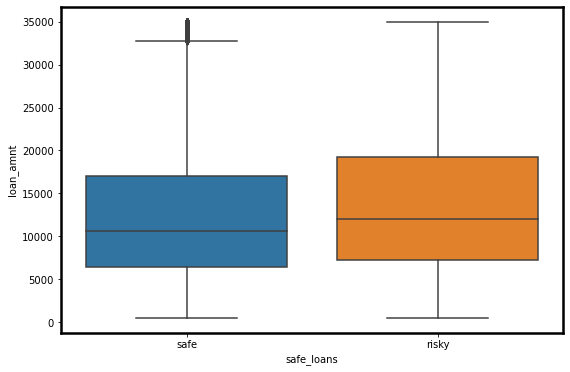

In [48]:
fig, ax = plt.subplots(figsize=(9, 6))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)
    
sns.boxplot(x="safe_loans", y="loan_amnt", data=df_lending)

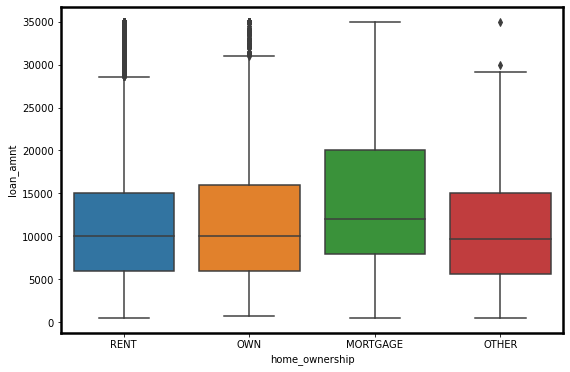

In [51]:
fig, ax = plt.subplots(figsize=(9, 6))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)
    
sns.boxplot(x="home_ownership", y="loan_amnt", data=df_lending)

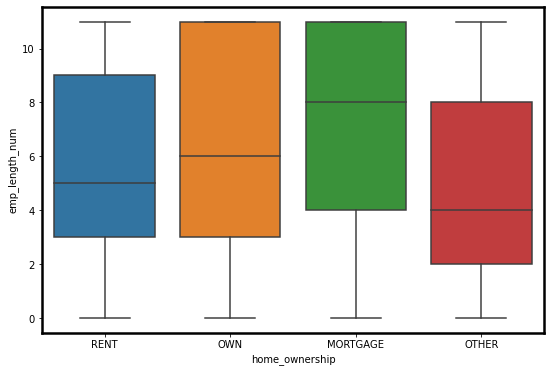

In [18]:
fig, ax = plt.subplots(figsize=(9, 6))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)
    
sns.boxplot(x="home_ownership", y="emp_length_num", data=df_data)

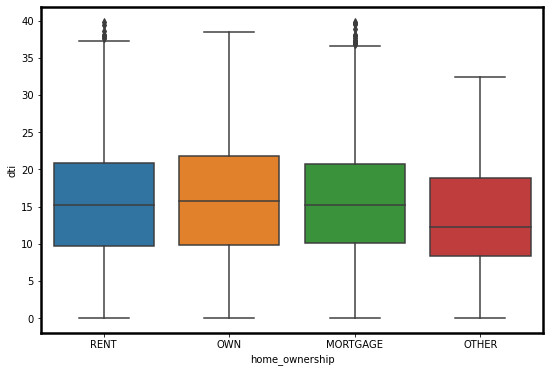

In [41]:
fig, ax = plt.subplots(figsize=(9, 6))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)
    
sns.boxplot(x="home_ownership", y="dti", data=df_data)

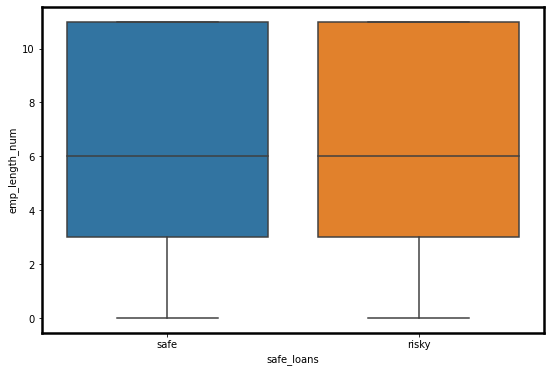

In [19]:
fig, ax = plt.subplots(figsize=(9, 6))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)
    
sns.boxplot(x="safe_loans", y="emp_length_num", data=df_data)

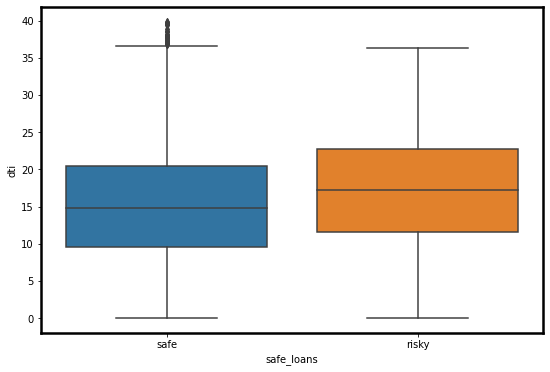

In [20]:
fig, ax = plt.subplots(figsize=(9, 6))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)
    
sns.boxplot(x="safe_loans", y="dti", data=df_data)

In [24]:
df_data.groupby(['home_ownership','safe_loans']).size()

home_ownership  safe_loans
MORTGAGE        risky         10020
                safe          49220
OTHER           risky            41
                safe            138
OWN             risky          1935
                safe           8008
RENT            risky         11154
                safe          42091
dtype: int64

In [26]:
df_data.groupby(['safe_loans']).dti.mean()

safe_loans
risky    17.169811
safe     15.107492
Name: dti, dtype: float64

In [27]:
df_data.groupby(['safe_loans']).emp_length_num.mean()

safe_loans
risky    6.305659
safe     6.385292
Name: emp_length_num, dtype: float64

In [31]:
df_data.columns

Index(['grade', 'sub_grade', 'short_emp', 'emp_length_num', 'home_ownership',
       'dti', 'purpose', 'term', 'last_delinq_none', 'last_major_derog_none',
       'revol_util', 'total_rec_late_fee', 'safe_loans'],
      dtype='object')

In [33]:
items = ['last_delinq_none','last_major_derog_none','revol_util' ,'total_rec_late_fee']

print(df_data.groupby(['safe_loans']).last_delinq_none.mean())


safe_loans
risky    0.584579
safe     0.588938
Name: last_delinq_none, dtype: float64


In [34]:
print(df_data.groupby(['safe_loans']).last_major_derog_none.mean())

safe_loans
risky    0.875551
safe     0.873523
Name: last_major_derog_none, dtype: float64


In [35]:
print(df_data.groupby(['safe_loans']).revol_util.mean()) 

safe_loans
risky    59.717187
safe     52.319519
Name: revol_util, dtype: float64


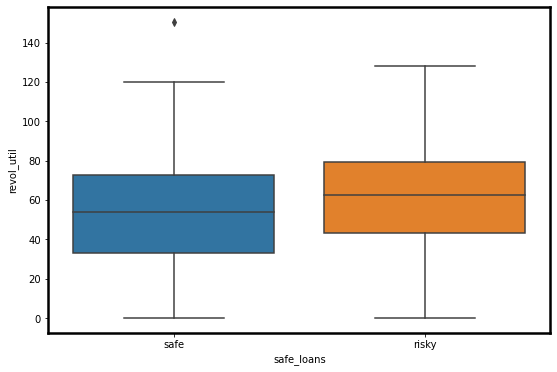

In [39]:
fig, ax = plt.subplots(figsize=(9, 6))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)
    
sns.boxplot(x="safe_loans", y="revol_util", data=df_data)

In [36]:
print(df_data.groupby(['safe_loans']).total_rec_late_fee.mean())

safe_loans
risky    2.187615
safe     0.405937
Name: total_rec_late_fee, dtype: float64


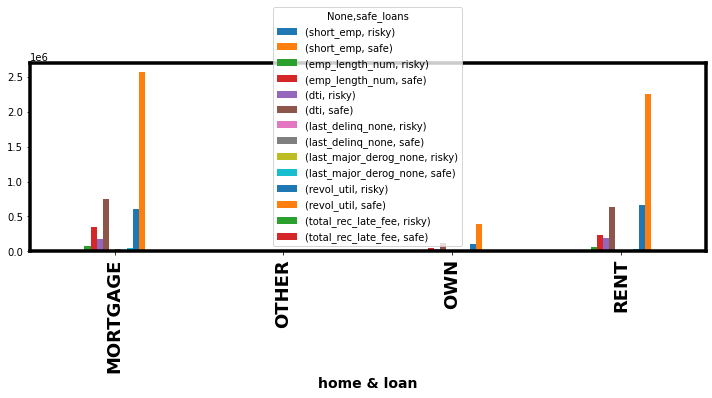

In [22]:
df_data.groupby(['home_ownership','safe_loans']).sum().unstack().plot(kind='bar',figsize=(10,5))

plt.xticks(fontsize=18,weight='bold')
plt.xlabel('home & loan', fontsize=14, weight='bold')
plt.gca().spines['top'].set_linewidth(3.5)
plt.gca().spines['right'].set_linewidth(3.5)
plt.gca().spines['bottom'].set_linewidth(3.5)
plt.gca().spines['left'].set_linewidth(3.5)
plt.tight_layout()

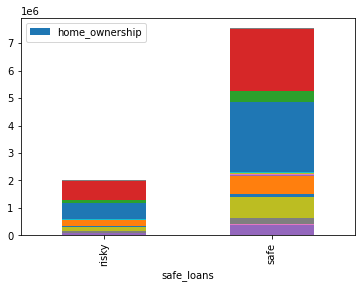

In [46]:
ax = df_data.groupby(['safe_loans','home_ownership']).sum().unstack().plot(kind='bar', stacked=True)
ax.legend(['home_ownership']);